In [160]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [1]:
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random
import argparse
from PIL import Image
from PIL.PngImagePlugin import PngInfo
from matplotlib.pyplot import imshow
from tqdm import tqdm
import os, sys

## Functions ##

In [2]:
class Args:
    in_file="KSJ.jpg"
    out_file = "./outtest.png"
    blur_kernel = 9
    n_clusters = 10
    min_area = 100
    poly_epsilon = 10
    quiet = False
    final_blur = False
    def __init__(self):
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
args = Args()
metadata= args.get_metadata()

Created args


In [4]:
def show(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.axis("off")
    plt.imshow(im)
    plt.show()

In [5]:
def cluster(im, n_clusters):
    im = im.reshape((im.shape[0] * im.shape[1], 3))
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km.fit(im)

    counts = {}
    reps = km.cluster_centers_

    # count colors per label
    for i in range(len(im)):
        if km.labels_[i] not in counts:
            counts[km.labels_[i]] = {}
        rgb = tuple(im[i])
        if rgb not in counts[km.labels_[i]]:
            counts[km.labels_[i]][rgb] = 0
        counts[km.labels_[i]][rgb] += 1

    # remap representative to most prominent color for ea label
    for label, hist in counts.items():
        flat = sorted(hist.items(), key=lambda x: x[1], reverse=True)
        col = 0
        # # Soften Edges
        # if sum(flat[0][0])>600:
        #     reps[label] = reps[label-1]
        # else:
        reps[label] = flat[0][0]
    # print(reps)
    return km.cluster_centers_, km.labels_

In [6]:
def remap_colors(im, reps, labels):
    orig_shape = im.shape
    im = im.reshape((im.shape[0] * im.shape[1], 3))
    for i in range(len(im)):
        im[i] = reps[labels[i]]
    return im.reshape(orig_shape)

In [7]:
def find_contours(im, reps, min_area): 
    contours = []
    for rep in reps:
        mask = cv2.inRange(im, rep-1, rep+1)
        # show(mask)
        conts, _ = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for cont in conts:
            area = cv2.contourArea(cont)
            if area >= min_area:
                contours.append((area, cont, rep))
    contours.sort(key=lambda x: x[0], reverse=True)
    return contours

In [8]:
def get_crops(image):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    crop_images = []
    for (x, y, w, h) in faces:
        crop_images.append(image[y:y+h, x:x+w])
    return faces , crop_images

In [21]:
def black_inpaint(fitler:np.ndarray):
    paint_mask = cv2.inRange(fitler, (0,0,0),(5,5,5))
    return cv2.inpaint(fitler, paint_mask, 1, flags=cv2.INPAINT_TELEA)

In [105]:
def smooth_blend(fitler:np.ndarray,orig:np.ndarray,coordinates:tuple,mask):
        """
            coordinates: (y,y+h,x,x+w)
        """
        mask= cv2.resize(mask,fitler.shape[:2])/255
        orig[coordinates[1]:coordinates[1]+coordinates[3], coordinates[0]:coordinates[0]+coordinates[2]] = np.add(np.multiply(orig[coordinates[1]:coordinates[1]+coordinates[3], coordinates[0]:coordinates[0]+coordinates[2]],mask),np.multiply(fitler,(1-mask)))
        return orig

In [11]:
def merge_images(file1, file2):
    """Merge two images into one, displayed side by side
    :param file1: path to first image file
    :param file2: path to second image file
    :return: the merged Image object
    """
    image1 = Image.open(file1)
    image2 = Image.open(file2)

    (width1, height1) = image1.size
    (width2, height2) = image2.size

    result_width = width1 + width2
    result_height = max(height1, height2)

    result = Image.new('RGB', (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width1, 0))
    return result

In [12]:
"""argp = argparse.ArgumentParser(description='Cutout filter.')
argp.add_argument('-in-file', type=str, required=True)
argp.add_argument(
    '-out-file', type=str, 
    help='If empty output is displayed with pyplot.')
argp.add_argument(
    '-n-clusters', type=int, default=3,
    help='Number of colors.')
argp.add_argument(
    '-blur-kernel', type=int, default=5,
    help='The size of the blur kernel.')
argp.add_argument(
    '-min-area', type=int, default=50,
    help='Contours with areas smaller than this are dropped.')
argp.add_argument(
    '-poly-epsilon', type=float, default=10,
    help='Maximum distance between original contour and its drawing.')
argp.add_argument(
    '-quiet', action='store_true', default=False,
    help='Do not print progress.')
argp.add_argument(
    '-final-blur', action='store_true', default=False,
    help='3 pixel blur on the output to clean up the jaggies.')
args = argp.parse_args()

if args.blur_kernel % 2 != 1:
    print('-blur-kernel must be an odd number')
    return 1

if args.min_area < 1:
    print('-min-area must be at least 1')
    return 1

if not args.quiet:
    print(f'Reading file {args.in_file}...')"""

"argp = argparse.ArgumentParser(description='Cutout filter.')\nargp.add_argument('-in-file', type=str, required=True)\nargp.add_argument(\n    '-out-file', type=str, \n    help='If empty output is displayed with pyplot.')\nargp.add_argument(\n    '-n-clusters', type=int, default=3,\n    help='Number of colors.')\nargp.add_argument(\n    '-blur-kernel', type=int, default=5,\n    help='The size of the blur kernel.')\nargp.add_argument(\n    '-min-area', type=int, default=50,\n    help='Contours with areas smaller than this are dropped.')\nargp.add_argument(\n    '-poly-epsilon', type=float, default=10,\n    help='Maximum distance between original contour and its drawing.')\nargp.add_argument(\n    '-quiet', action='store_true', default=False,\n    help='Do not print progress.')\nargp.add_argument(\n    '-final-blur', action='store_true', default=False,\n    help='3 pixel blur on the output to clean up the jaggies.')\nargs = argp.parse_args()\n\nif args.blur_kernel % 2 != 1:\n    print('-

## Single Face experiments

### Param Configs

In [97]:
class Args:
    in_file="KSJ.jpg"
    out_file = "./outtest.png"
    blur_kernel = 23
    n_clusters = 11
    min_area = 200
    poly_epsilon = 15
    quiet = False
    final_blur = False
    def __init__(self):
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
args = Args()
metadata= args.get_metadata()

Created args


In [98]:
mask = cv2.imread("./masks/mask5.png")

### Code

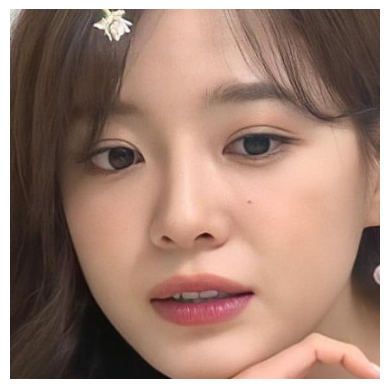

Blurring with size 23...
Clustering around 11 colors...
reps: [[186. 204. 251.]
 [ 78.  83.  92.]
 [114. 139. 176.]
 [ 53.  61.  78.]
 [ 26.  28.  39.]
 [144. 170. 216.]
 [110. 136. 173.]
 [151. 177. 224.]
 [ 41.  51.  68.]
 [ 16.  16.  16.]
 [ 92. 104. 133.]] 
labels [0 0 0 ... 7 7 7]
Remapping image to representative colors...
Finding contours with area gte 200...
Drawing...
Drawing Complete
{'blur_kernel': 23, 'n_clusters': 11, 'min_area': 200, 'poly_epsilon': 15, 'quiet': False, 'final_blur': False}


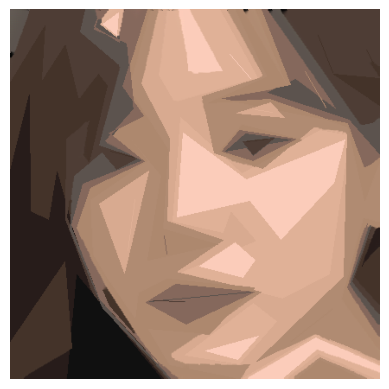

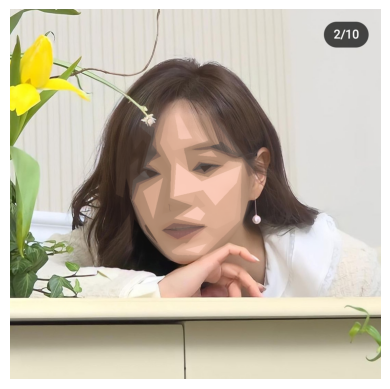

In [106]:
orig = cv2.imread(args.in_file)
im = orig.copy()
# show(im)

ret_tup = get_crops(im)
im = ret_tup[1][0]
x,y,w,h = ret_tup[0][0]

show(im)

if not args.quiet:
    print(f'Blurring with size {args.blur_kernel}...')

im = cv2.GaussianBlur(im, (args.blur_kernel, args.blur_kernel), 0)
# show(im)

if not args.quiet:
    print(f'Clustering around {args.n_clusters} colors...')

reps, labels = cluster(im, args.n_clusters)

print("reps:",reps,"\nlabels",labels)

if not args.quiet:
    print('Remapping image to representative colors...')

im = remap_colors(im, reps, labels)
# show(im)

if not args.quiet:
    print(f'Finding contours with area gte {args.min_area}...')

contours = find_contours(im, reps, args.min_area)

if not args.quiet:
    print(f'Drawing...')

canvas = np.zeros(im.shape, np.uint8)
# show(im)
for area, cont, rep in contours:
    approx = cv2.approxPolyDP(cont, args.poly_epsilon, True)
    cv2.drawContours(canvas, [approx], -1, rep, -1)

if args.final_blur:
    canvas = cv2.GaussianBlur(canvas, (3, 3), 0)
    
if not args.quiet:
    print(f'Drawing Complete')

canvas = black_inpaint(canvas)
orig = smooth_blend(canvas,orig,(x,y,w,h),mask)
# if args.out_file is None:
print(metadata)
show(canvas)
show(orig)
# else:
#     cv2.imwrite(args.out_file, canvas)

In [ ]:
cv2.im

### Black cluster experiments

In [56]:
can2 = canvas.copy()

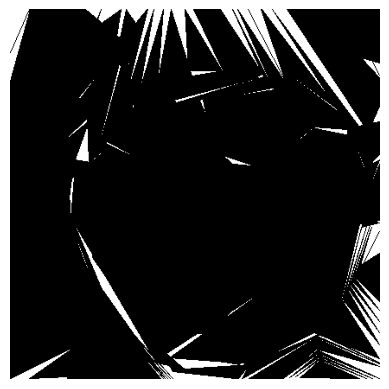

In [57]:
mask = cv2.inRange(can2, (0,0,0),(5,5,5))
show(mask)

In [58]:
image = cv2.inpaint(can2, mask, 1, flags=cv2.INPAINT_TELEA)

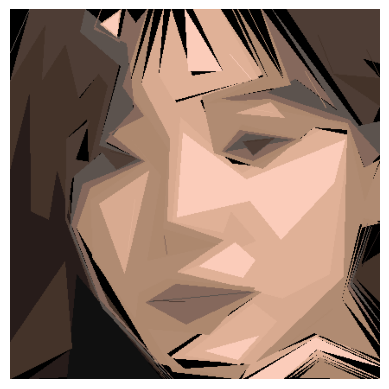

In [59]:
show(canvas)

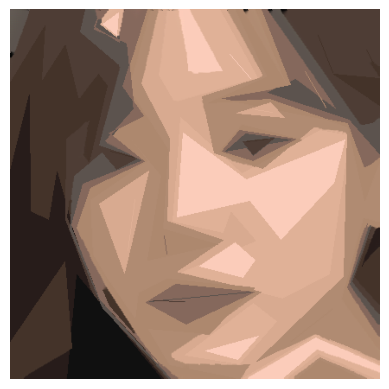

In [60]:
show(image)

In [61]:
cv2.imwrite("inPaint/KSJ_v1.png", canvas)
cv2.imwrite("inPaint/KSJ_v2.png", image)
stitch= merge_images("inPaint/KSJ_v1.png","inPaint/KSJ_v2.png")
# show(stitch)
stitch.save("inPaint/comp_KSJ.png")

## Multiface

In [50]:
mask = cv2.imread('./masks/mask5.png',0).astype(np.float32)

In [112]:
class Args:
    in_file="original.png"
    out_file = "outs/"+in_file.split('.')[0]+".png"
    blur_kernel = 5
    n_clusters = 7
    min_area = 200
    poly_epsilon = 14
    quiet = True
    final_blur = False
    def __init__(self):
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
args = Args()
metadata= args.get_metadata()

Created args


In [74]:
metadata

{'blur_kernel': 5,
 'n_clusters': 7,
 'min_area': 200,
 'poly_epsilon': 14,
 'quiet': True,
 'final_blur': False}

In [77]:
faces

array([[ 635,  140,  151,  151],
       [1041,  262,   64,   64],
       [ 992,  173,  135,  135],
       [ 300,  426,  161,  161],
       [1357,  429,  196,  196],
       [ 300,  598,  123,  123],
       [ 555,  737,   61,   61]], dtype=int32)

In [78]:
def area(bb):
    return bb[2]*bb[3]

In [82]:
apply_area = np.vectorize(area,signature='(n)->()')

38416

Threshold= 38416.0


  0%|                                                                              | 0/7 [00:00<?, ?it/s]

Area: 22801
Blurring with size 5...


 14%|██████████                                                            | 1/7 [00:01<00:06,  1.11s/it]

Area: 4096
Blurring with size 5...


 29%|████████████████████                                                  | 2/7 [00:02<00:05,  1.07s/it]

Area: 18225
Blurring with size 5...


 43%|██████████████████████████████                                        | 3/7 [00:03<00:04,  1.09s/it]

Area: 25921
Blurring with size 5...


 57%|████████████████████████████████████████                              | 4/7 [00:04<00:03,  1.12s/it]

Area: 38416
Blurring with size 5...


 71%|██████████████████████████████████████████████████                    | 5/7 [00:05<00:02,  1.19s/it]

Area: 15129
Blurring with size 5...


 86%|████████████████████████████████████████████████████████████          | 6/7 [00:06<00:01,  1.14s/it]

Area: 3721
Blurring with size 5...


100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.12s/it]


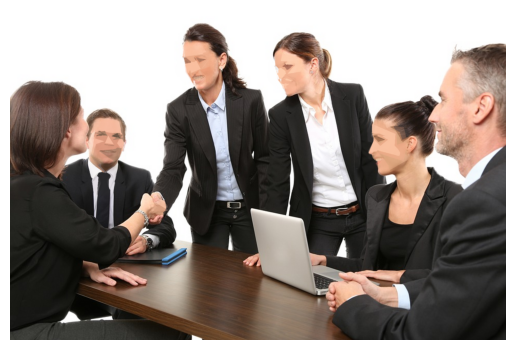

In [113]:
orig = cv2.imread(args.in_file)
img = orig.copy()
# show(im)
mask = cv2.imread("./masks/mask5.png")
faces,images = get_crops(img)
outputs = []
threshold = np.max(apply_area(faces))/1
print("Threshold=",threshold)
for i in tqdm(range(len(images))):
    print("Area:",faces[i][2]*faces[i][3])
    # show(images[i])
    if(faces[i][2]*faces[i][3] <= threshold):
        im = images[i]

        print(f'Blurring with size {args.blur_kernel}...')

        im = cv2.GaussianBlur(im, (args.blur_kernel, args.blur_kernel), 0)
        # show(im)

        if not args.quiet:
            print(f'Clustering around {args.n_clusters} colors...')

        reps, labels = cluster(im, args.n_clusters)

        if not args.quiet:
            print('Remapping image to representative colors...')

        im = remap_colors(im, reps, labels)
        # show(im)

        if not args.quiet:
            print(f'Finding contours with area gte {args.min_area}...')

        contours = find_contours(im, reps, args.min_area)

        if not args.quiet:
            print("Drawing{}...".format(i))

        canvas = np.zeros(im.shape, np.uint8)
        # show(im)
        for area, cont, rep in contours:
            approx = cv2.approxPolyDP(cont, args.poly_epsilon, True)
            cv2.drawContours(canvas, [approx], -1, rep, -1)

        if args.final_blur:
            canvas = cv2.GaussianBlur(canvas, (3, 3), 0)
        # outputs.append(canvas)
        canvas = black_inpaint(canvas)
        orig = smooth_blend(canvas,orig,faces[i],mask)

# orig[y:y+h, x:x+w] = canvas
# # if args.out_file is None:
# print(metadata)
show(orig)
# else:
#     cv2.imwrite(args.out_file, canvas)

In [66]:
cv2.imwrite("inPaint/meeting_v2.png", orig)

True

In [67]:
# print(metadata)
# show(orig)
# cv2.imwrite(args.out_file, orig)
stitch= merge_images("inPaint/meeting_v1.png","inPaint/meeting_v2.png")
# show(stitch)
stitch.save("inPaint/comp_meeting.png")

## Yolo Face

In [15]:
from yoloface import face_analysis

In [92]:
class Args:
    in_file="me2.jpg"
    out_file = "outs/yolo_"+in_file.split('.')[0]+".png"
    blur_kernel = 7
    n_clusters = 3
    min_area = 10
    poly_epsilon = 5
    quiet = True
    final_blur = False
    def __init__(self):
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
args = Args()
metadata= args.get_metadata()

Created args


In [93]:
face=face_analysis()

NameError: name 'face_analysis' is not defined

In [94]:
orig,faces,conf=face.face_detection(image_path=args.in_file,model='full')
# face.show_output(orig,faces)
show(orig)

NameError: name 'face' is not defined

Threshold= 19208.0


100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.69it/s]


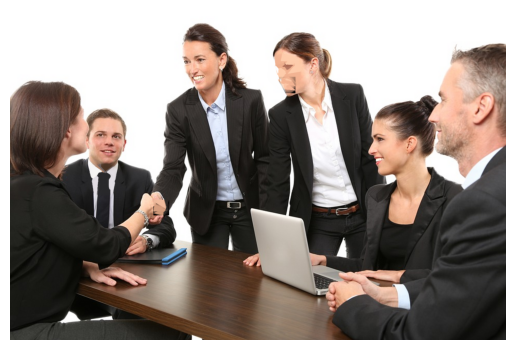

In [90]:
# orig,faces,conf=face.face_detection(image_path=args.in_file,model='full')
img = orig.copy()
# show(im)
threshold = np.max(apply_area(faces))/2
print("Threshold=",threshold)
for i in tqdm(range(len(images))):
    # print("Area:",faces[i][2]*faces[i][3])
    # show(images[i])
    if(faces[i][2]*faces[i][3] < threshold):
        im = images[i]
        if not args.quiet:
            print(f'Blurring with size {args.blur_kernel}...')

        im = cv2.GaussianBlur(im, (args.blur_kernel, args.blur_kernel), 0)
        # show(im)

        if not args.quiet:
            print(f'Clustering around {args.n_clusters} colors...')

        reps, labels = cluster(im, args.n_clusters)

        if not args.quiet:
            print('Remapping image to representative colors...')

        im = remap_colors(im, reps, labels)
        # show(im)

        if not args.quiet:
            print(f'Finding contours with area gte {args.min_area}...')

        contours = find_contours(im, reps, args.min_area)

        if not args.quiet:
            print("Drawing{}...".format(i))

        canvas = np.zeros(im.shape, np.uint8)
        # show(im)
        for area, cont, rep in contours:
            approx = cv2.approxPolyDP(cont, args.poly_epsilon, True)
            cv2.drawContours(canvas, [approx], -1, rep, -1)

        if args.final_blur:
            canvas = cv2.GaussianBlur(canvas, (3, 3), 0)
        # outputs.append(canvas)
        x,y,w,h = faces[i]
        canvas = black_inpaint(canvas)
        orig = smooth_blend(canvas,orig,(y,y+h, x,x+w),mask)

# orig[y:y+h, x:x+w] = canvas
# # if args.out_file is None:
# print(metadata)
show(orig)


In [ ]:
print(metadata)
show(orig)
cv2.imwrite(args.out_file, orig)
stitch= merge_images(args.in_file,args.out_file)
# show(stitch)
#stitch.save("./comps/compare_"+args.out_file.split("/")[1])

In [ ]:
stitch

### Image Generation for Survery ###

In [ ]:
arg_list = []
for file_name in os.listdir("/Users/aseem/Documents/Privacy_598/crowd_images/"):
    if file_name.endswith('.jpeg'):
        file_path = os.path.join("/Users/aseem/Documents/Privacy_598/crowd_images/",file_name)

        file_args = Args(input_path=file_path)
        arg_list.append(file_args)
    

In [ ]:
for a in arg_list:
    print(a.in_file)

In [147]:
class Args:
    blur_kernel = 5
    n_clusters = 3
    min_area = 100
    poly_epsilon = 1
    quiet = True
    final_blur = False
    def __init__(self,input_path):
        self.in_file = input_path
        self.out_file = "outs/"+self.in_file.split('/')[-1].split('.')[0]+".png"
        print("Created args")
    def get_metadata(self):
        return {"blur_kernel" : self.blur_kernel,
                "n_clusters" : self.n_clusters,
                "min_area" : self.min_area,
                "poly_epsilon" : self.poly_epsilon,
                "quiet" : self.quiet,
                "final_blur" : self.final_blur
               }
            
# args = Args()
# metadata= args.get_metadata()

In [140]:
# orig,faces,conf=face.face_detection(image_path=args.in_file,model='full')
def driver(args):
    orig,faces,conf=face.face_detection(image_path=args.in_file,model='full')

    img = orig.copy()
    outputs = []
    threshold= 0
    for i in faces: 
        t = i[2]*i[3]
        if(t>threshold):
            threshold = t
    threshold /=3
    print("Threshold=",threshold)
    threshold = [472217, 477818]
    print(len(faces))
    for i in range(len(faces)):
        print("Area:",faces[i][2]*faces[i][3])
        # show(images[i])
        # print("-",end="")
        x,y,w,h = faces[i]
        if(w*h  not in threshold) and (x>0 and y>0):
            im = orig[y:y+w, x:x+h]
            # show(im)
            if not args.quiet:
                print(f'Blurring with size {args.blur_kernel}...')

            try:
                im = cv2.GaussianBlur(im, (args.blur_kernel, args.blur_kernel), 0)
            except Exception as e:
                print(x,y,w,h)
                print(im.shape)
            # show(im)

            if not args.quiet:
                print(f'Clustering around {args.n_clusters} colors...')

            reps, labels = cluster(im, args.n_clusters)

            if not args.quiet:
                print('Remapping image to representative colors...')

            im = remap_colors(im, reps, labels)
            # show(im)

            if not args.quiet:
                print(f'Finding contours with area gte {args.min_area}...')

            contours = find_contours(im, reps, args.min_area)

            if not args.quiet:
                print("Drawing{}...".format(i))

            canvas = np.zeros(im.shape, np.uint8)
            # show(im)
            for area, cont, rep in contours:
                approx = cv2.approxPolyDP(cont, args.poly_epsilon, True)
                cv2.drawContours(canvas, [approx], -1, rep, -1)

            if args.final_blur:
                canvas = cv2.GaussianBlur(canvas, (3, 3), 0)
            # print(canvas.shape)
            outputs.append(canvas)
        else:
            outputs.append([False,0,0,0])

    for i in range(len(outputs)):
        if(not isinstance(outputs[i][0],bool)):
            x,y,w,h = faces[i]
            if x < 0 or y < 0:
                continue
            orig[y:y+w, x:x+h] = outputs[i]


    print(args.get_metadata())
    #show(orig)
    cv2.imwrite(args.out_file, orig)
    stitch= merge_images(args.in_file,args.out_file)
    
    plt.imshow(stitch)
    plt.show()
    
    show(orig)


In [146]:
file_path = "/Users/aseem/Documents/Privacy_598/crowd_images/protests.png"

In [142]:
file_args = Args(input_path=file_path)

Created args


In [143]:
file_args.get_metadata()

{'blur_kernel': 5,
 'n_clusters': 3,
 'min_area': 100,
 'poly_epsilon': 50,
 'quiet': True,
 'final_blur': False}

Threshold= 159272.66666666666
7
Area: 413436
Area: 477818
Area: 135036
Area: 472217
Area: 390042
Area: 243882
Area: 158775
{'blur_kernel': 5, 'n_clusters': 3, 'min_area': 100, 'poly_epsilon': 50, 'quiet': True, 'final_blur': False}


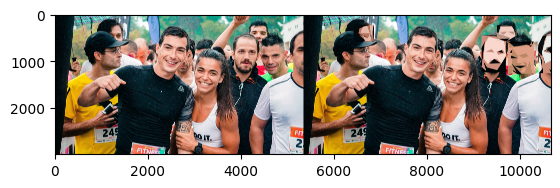

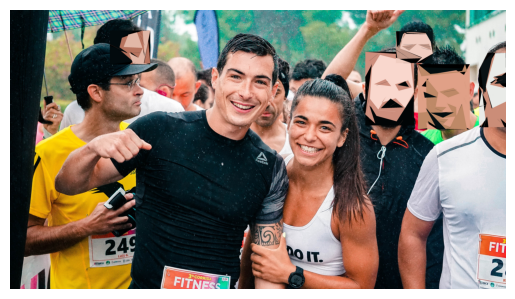

In [144]:
driver(file_args)

In [90]:
file_args

In [148]:
original = cv2.imread("/Users/aseem/Downloads/final_survey/original.png")
img_1 = cv2.imread("/Users/aseem/Downloads/final_survey/1.png")
img_2 = cv2.imread("/Users/aseem/Downloads/final_survey/2.png")
img_3 = cv2.imread("/Users/aseem/Downloads/final_survey/3.png")

In [155]:
img_1.shape

(703, 703, 3)

In [156]:
original.shape


(703, 703, 3)

In [157]:
img_2.shape

(703, 703, 3)

In [158]:
img_3.shape

(703, 698, 3)

In [154]:
dim = 703
def resize_image(im, dim):
    return cv2.resize(im, (dim,dim))

original = resize_image(original,dim)
img_1 = resize_image(img_1, dim)
img_2 = resize_image(img_2, dim)
img_3 = resize_image(im)

In [163]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from PIL import Image

org = Image.open("/Users/aseem/Downloads/final_survey/original.png")
im1 = Image.open("/Users/aseem/Downloads/final_survey/1.png")
im2 = Image.open("/Users/aseem/Downloads/final_survey/2.png")
im3 = Image.open("/Users/aseem/Downloads/final_survey/3.png")

In [168]:
org.size

(703, 703)

In [167]:
org = org.resize((dim,dim))

In [169]:
im1 = im1.resize((dim,dim))
im2 = im2.resize((dim,dim))
im3 = im3.resize((dim,dim))

In [177]:
fig = plt.figure(figsize=(4., 4.))

<Figure size 400x400 with 0 Axes>

In [178]:
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

In [190]:
for ax, im in zip(grid, [original, img_1, img_2, img_3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    plt.show()
plt.show()

In [180]:
grid

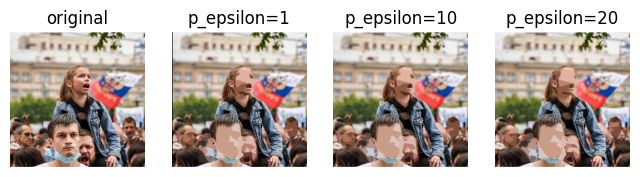

In [210]:
plt.figure(figsize=(8,20))
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(org)
plt.title('original')

plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(im1)
plt.title('p_epsilon=1')

plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(im2)
plt.title('p_epsilon=10')

plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(im3)
plt.title('p_epsilon=20')

plt.savefig('grid.png', transparent=True)